# 📊 Exploración de Datos Sintéticos de Termocuplas

Este notebook contiene la exploración inicial de los datos sintéticos de termocuplas para validar el flujo de trabajo de análisis térmico antes de implementar VFLUX2 en Python.

## Objetivos:
1. ✅ Cargar datos sintéticos generados
2. ✅ Alinear temporalmente los 3 sensores
3. ✅ Visualizar series temporales
4. ✅ Realizar análisis espectral (FFT)
5. ✅ Calcular amplitudes y fases por sensor
6. ✅ Calcular ΔA y Δφ entre sensores

In [16]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.optimize import curve_fit
import sys
from pathlib import Path

# Configuración de gráficos
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

# Agregar el directorio src al path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


## 1. Carga de Datos Sintéticos

Cargamos el archivo Excel generado con datos sintéticos de 3 sensores de temperatura.

In [17]:
# Importar función de carga
from io_utils import load_termocuplas_excel

# Cargar datos
data_path = Path.cwd().parent / 'data' / 'raw' / 'termocuplas_sinteticas.xlsx'
df_raw = load_termocuplas_excel(data_path)

# Información básica
print(f"📁 Archivo cargado: {data_path.name}")
print(f"📊 Dimensiones: {df_raw.shape}")
print(f"📅 Periodo: {df_raw['fecha1'].min()} a {df_raw['fecha1'].max()}")
print(f"⏱️  Frecuencia: cada 15 minutos")
print(f"\n🔍 Primeras filas:")
df_raw.head()

📁 Archivo cargado: termocuplas_sinteticas.xlsx
📊 Dimensiones: (288, 6)
📅 Periodo: 2025-01-01 00:00:00 a 2025-01-03 23:45:00
⏱️  Frecuencia: cada 15 minutos

🔍 Primeras filas:


,fecha1,temp1,fecha2,temp2,fecha3,temp3
0,2025-01-01 00:00:00,20.000000,2025-01-01 00:02:00,19.017453,2025-01-01 00:04:00,18.020943
1,2025-01-01 00:15:00,20.196209,2025-01-01 00:17:00,19.148217,2025-01-01 00:19:00,18.099370
2,2025-01-01 00:30:00,20.391579,2025-01-01 00:32:00,19.278346,2025-01-01 00:34:00,18.177371
3,2025-01-01 00:45:00,20.585271,2025-01-01 00:47:00,19.407284,2025-01-01 00:49:00,18.254613
4,2025-01-01 01:00:00,20.776457,2025-01-01 01:02:00,19.534477,2025-01-01 01:04:00,18.330765


## 2. Alineación Temporal de Sensores

Los sensores tienen pequeños desfases temporales (2 y 4 minutos). Usamos la función `align_and_resample` para alinearlos.

In [20]:
# Importar función de alineación (recargar módulo si ya se importó)
import importlib
import preprocess
importlib.reload(preprocess)
from preprocess import align_and_resample

# Alinear sensores
df_aligned = align_and_resample(df_raw, freq="15min")

print(f"✅ Sensores alineados correctamente")
print(f"📊 Dimensiones alineadas: {df_aligned.shape}")
print(f"📈 Valores no-nulos por columna:")
print(f"   temp1: {df_aligned['temp1'].notna().sum()}/{len(df_aligned)}")
print(f"   temp2: {df_aligned['temp2'].notna().sum()}/{len(df_aligned)}")
print(f"   temp3: {df_aligned['temp3'].notna().sum()}/{len(df_aligned)}")
print(f"\n🔍 Primeras filas:")
df_aligned.head()

✅ Sensores alineados correctamente
📊 Dimensiones alineadas: (288, 4)
📈 Valores no-nulos por columna:
   temp1: 288/288
   temp2: 288/288
   temp3: 288/288

🔍 Primeras filas:


,fecha,temp1,temp2,temp3
0,2025-01-01 00:00:00,20.000000,19.000018,18.000029
1,2025-01-01 00:15:00,20.196209,19.130782,18.078456
2,2025-01-01 00:30:00,20.391579,19.260996,18.156571
3,2025-01-01 00:45:00,20.585271,19.390092,18.234015
4,2025-01-01 01:00:00,20.776457,19.517518,18.310458


## 3. Visualización de Series Temporales

Graficamos las 3 series de temperatura para observar el comportamiento sinusoidal y los desfases.

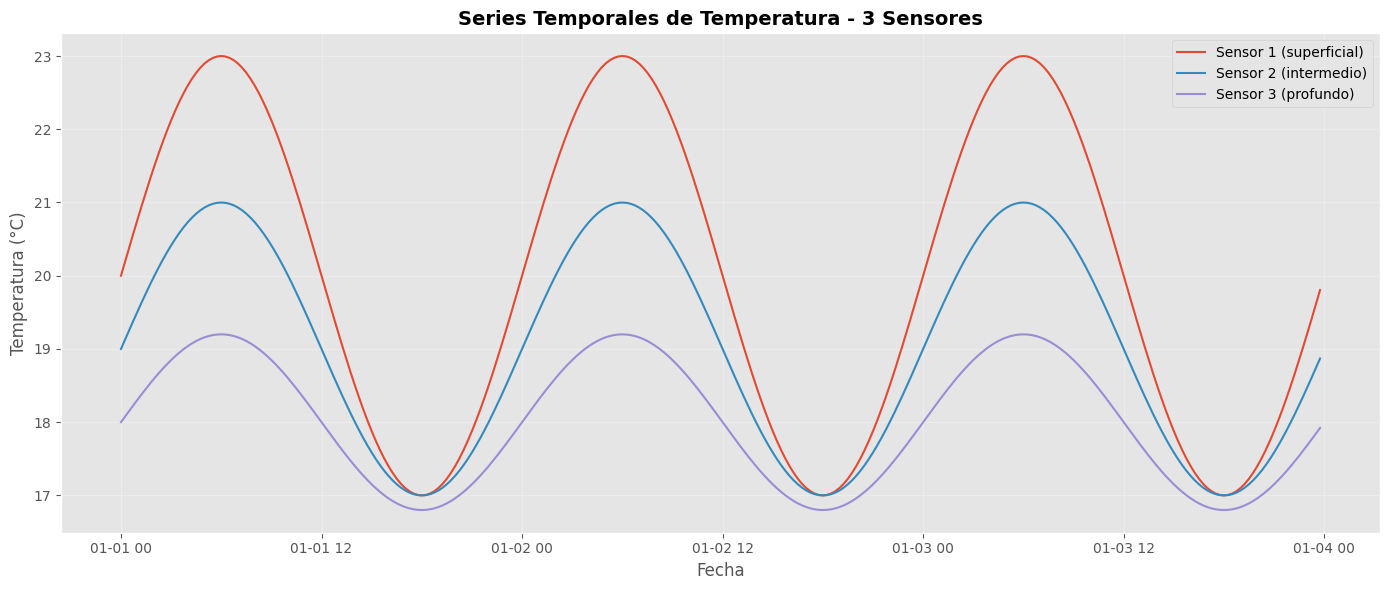

📈 Se observa claramente:
   • Ciclo diario sinusoidal en los 3 sensores
   • Atenuación de amplitud con la profundidad (temp1 > temp2 > temp3)
   • Desfase temporal entre sensores


In [21]:
# Gráfico de series temporales
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df_aligned['fecha'], df_aligned['temp1'], label='Sensor 1 (superficial)', linewidth=1.5)
ax.plot(df_aligned['fecha'], df_aligned['temp2'], label='Sensor 2 (intermedio)', linewidth=1.5)
ax.plot(df_aligned['fecha'], df_aligned['temp3'], label='Sensor 3 (profundo)', linewidth=1.5)

ax.set_xlabel('Fecha', fontsize=12)
ax.set_ylabel('Temperatura (°C)', fontsize=12)
ax.set_title('Series Temporales de Temperatura - 3 Sensores', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("📈 Se observa claramente:")
print("   • Ciclo diario sinusoidal en los 3 sensores")
print("   • Atenuación de amplitud con la profundidad (temp1 > temp2 > temp3)")
print("   • Desfase temporal entre sensores")

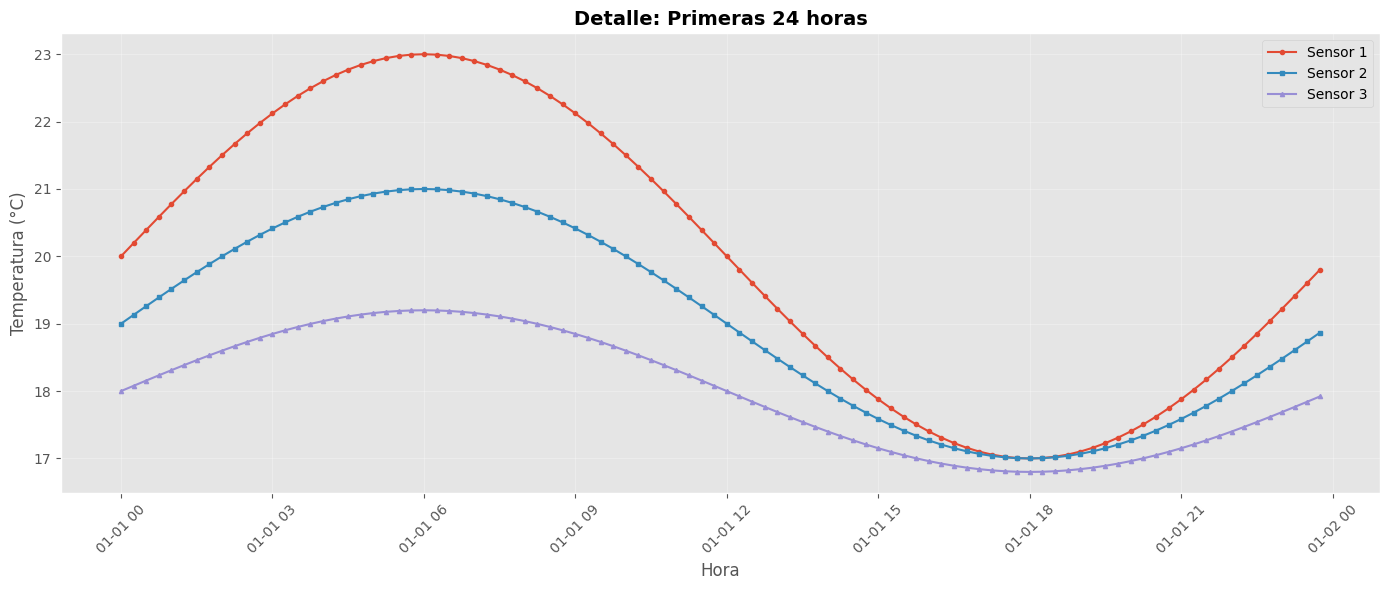

In [22]:
# Zoom a las primeras 24 horas para ver mejor el patrón
fig, ax = plt.subplots(figsize=(14, 6))

mask_24h = df_aligned['fecha'] < df_aligned['fecha'].min() + pd.Timedelta(hours=24)
df_24h = df_aligned[mask_24h]

ax.plot(df_24h['fecha'], df_24h['temp1'], 'o-', label='Sensor 1', markersize=3)
ax.plot(df_24h['fecha'], df_24h['temp2'], 's-', label='Sensor 2', markersize=3)
ax.plot(df_24h['fecha'], df_24h['temp3'], '^-', label='Sensor 3', markersize=3)

ax.set_xlabel('Hora', fontsize=12)
ax.set_ylabel('Temperatura (°C)', fontsize=12)
ax.set_title('Detalle: Primeras 24 horas', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Análisis Espectral (FFT)

Aplicamos la Transformada Rápida de Fourier para identificar las frecuencias dominantes en cada sensor.

In [23]:
# Función para calcular FFT
def compute_fft_spectrum(temperature_series, sampling_interval_hours=0.25):
    """
    Calcula el espectro FFT de una serie de temperatura.
    
    Parameters:
    -----------
    temperature_series : array-like
        Serie de temperatura
    sampling_interval_hours : float
        Intervalo de muestreo en horas (default: 0.25 = 15 min)
    
    Returns:
    --------
    freqs_per_day : array
        Frecuencias en ciclos por día
    amplitudes : array
        Amplitudes normalizadas
    """
    n = len(temperature_series)
    
    # Eliminar tendencia (detrend)
    temp_detrended = temperature_series - np.mean(temperature_series)
    
    # FFT
    yf = fft(temp_detrended)
    
    # Frecuencias en ciclos por hora
    freqs_per_hour = fftfreq(n, sampling_interval_hours)
    
    # Convertir a ciclos por día
    freqs_per_day = freqs_per_hour * 24
    
    # Solo frecuencias positivas
    positive_freq_idx = freqs_per_day > 0
    freqs_pos = freqs_per_day[positive_freq_idx]
    
    # Amplitudes normalizadas
    amplitudes = 2.0 / n * np.abs(yf[positive_freq_idx])
    
    return freqs_pos, amplitudes

print("✅ Función FFT definida")

✅ Función FFT definida


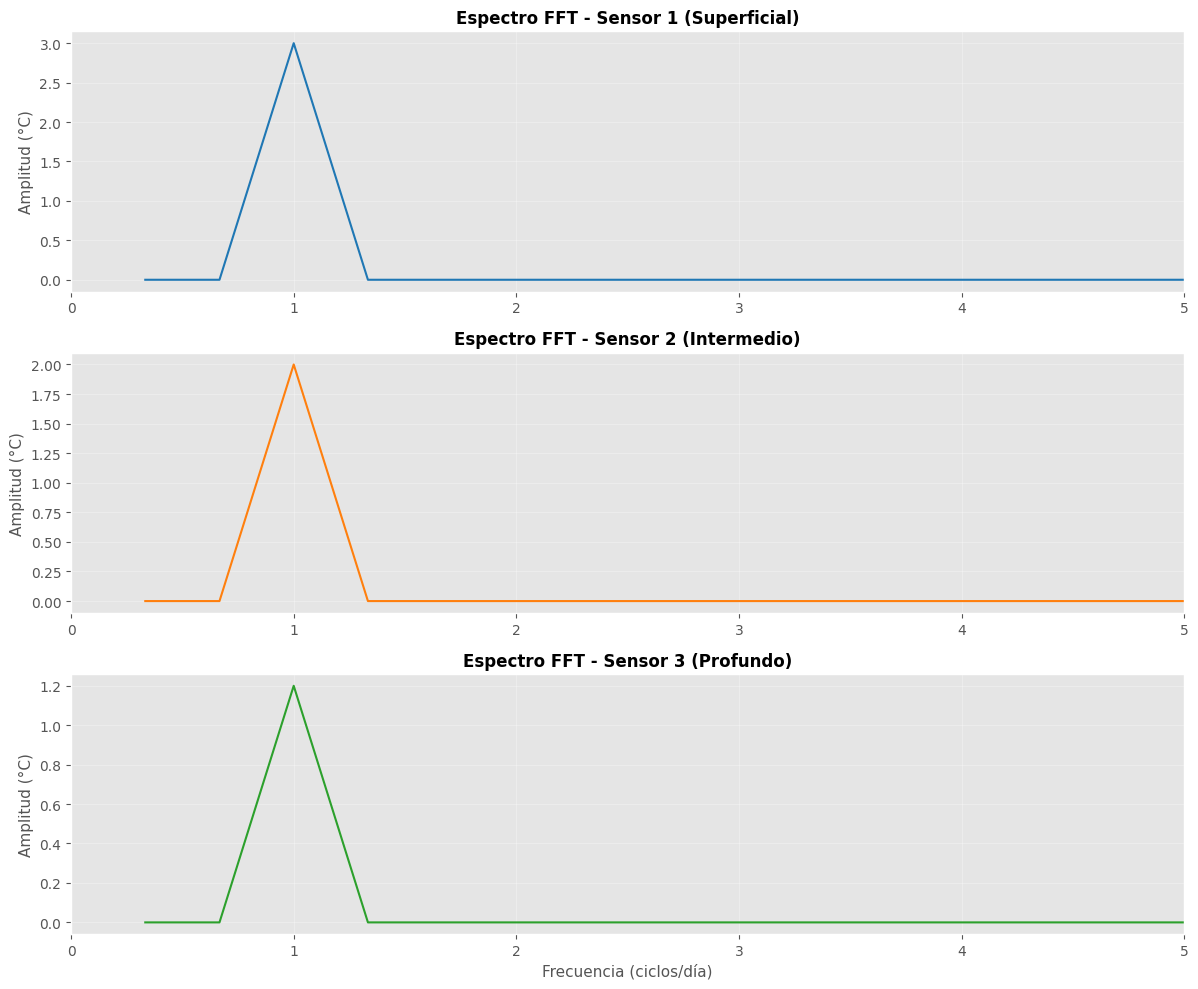

📊 Frecuencia dominante esperada: 1 ciclo/día (frecuencia diaria)


In [24]:
# Calcular FFT para cada sensor
freqs1, amps1 = compute_fft_spectrum(df_aligned['temp1'].values)
freqs2, amps2 = compute_fft_spectrum(df_aligned['temp2'].values)
freqs3, amps3 = compute_fft_spectrum(df_aligned['temp3'].values)

# Graficar espectros
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Sensor 1
axes[0].plot(freqs1, amps1, linewidth=1.5, color='tab:blue')
axes[0].set_ylabel('Amplitud (°C)', fontsize=11)
axes[0].set_title('Espectro FFT - Sensor 1 (Superficial)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(0, 5)

# Sensor 2
axes[1].plot(freqs2, amps2, linewidth=1.5, color='tab:orange')
axes[1].set_ylabel('Amplitud (°C)', fontsize=11)
axes[1].set_title('Espectro FFT - Sensor 2 (Intermedio)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, 5)

# Sensor 3
axes[2].plot(freqs3, amps3, linewidth=1.5, color='tab:green')
axes[2].set_xlabel('Frecuencia (ciclos/día)', fontsize=11)
axes[2].set_ylabel('Amplitud (°C)', fontsize=11)
axes[2].set_title('Espectro FFT - Sensor 3 (Profundo)', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].set_xlim(0, 5)

plt.tight_layout()
plt.show()

print("📊 Frecuencia dominante esperada: 1 ciclo/día (frecuencia diaria)")

## 5. Ajuste Armónico - Cálculo de Amplitud y Fase

Ajustamos un modelo sinusoidal a cada sensor para extraer los parámetros: amplitud (A) y fase (φ).

In [25]:
# Función de modelo armónico
def harmonic_model(t, A_mean, A_amp, omega, phi):
    """
    Modelo armónico: T(t) = A_mean + A_amp * sin(omega * t + phi)
    
    Parameters:
    -----------
    t : array
        Tiempo en horas desde el inicio
    A_mean : float
        Temperatura media (offset)
    A_amp : float
        Amplitud de la oscilación
    omega : float
        Frecuencia angular (rad/hora)
    phi : float
        Fase inicial (radianes)
    """
    return A_mean + A_amp * np.sin(omega * t + phi)

# Función para ajustar modelo
def fit_harmonic_params(time_hours, temperature):
    """
    Ajusta parámetros armónicos a una serie de temperatura.
    
    Returns:
    --------
    dict con 'mean', 'amplitude', 'omega', 'phase'
    """
    # Estimación inicial
    mean_temp = np.mean(temperature)
    amp_temp = (np.max(temperature) - np.min(temperature)) / 2
    omega_daily = 2 * np.pi / 24  # rad/hora para ciclo diario
    phi_init = 0
    
    # Ajuste con curve_fit
    p0 = [mean_temp, amp_temp, omega_daily, phi_init]
    
    try:
        popt, _ = curve_fit(harmonic_model, time_hours, temperature, p0=p0, maxfev=5000)
        
        return {
            'mean': popt[0],
            'amplitude': popt[1],
            'omega': popt[2],
            'phase': popt[3],
            'period_hours': 2 * np.pi / popt[2]
        }
    except:
        return None

print("✅ Funciones de ajuste armónico definidas")

✅ Funciones de ajuste armónico definidas


In [26]:
# Crear vector de tiempo en horas
t_start = df_aligned['fecha'].min()
time_hours = (df_aligned['fecha'] - t_start).dt.total_seconds() / 3600

# Ajustar modelo a cada sensor
params1 = fit_harmonic_params(time_hours.values, df_aligned['temp1'].values)
params2 = fit_harmonic_params(time_hours.values, df_aligned['temp2'].values)
params3 = fit_harmonic_params(time_hours.values, df_aligned['temp3'].values)

# Mostrar resultados
print("=" * 70)
print("PARÁMETROS ARMÓNICOS AJUSTADOS")
print("=" * 70)
print(f"\n{'Parámetro':<20} {'Sensor 1':<15} {'Sensor 2':<15} {'Sensor 3':<15}")
print("-" * 70)
print(f"{'Temp. Media (°C)':<20} {params1['mean']:>14.3f} {params2['mean']:>14.3f} {params3['mean']:>14.3f}")
print(f"{'Amplitud (°C)':<20} {params1['amplitude']:>14.3f} {params2['amplitude']:>14.3f} {params3['amplitude']:>14.3f}")
print(f"{'Fase (rad)':<20} {params1['phase']:>14.3f} {params2['phase']:>14.3f} {params3['phase']:>14.3f}")
print(f"{'Periodo (horas)':<20} {params1['period_hours']:>14.2f} {params2['period_hours']:>14.2f} {params3['period_hours']:>14.2f}")
print("=" * 70)

print("\n✅ Valores esperados (datos sintéticos):")
print("   • Sensor 1: Media=20°C, Amplitud=3°C")
print("   • Sensor 2: Media=19°C, Amplitud=2°C")
print("   • Sensor 3: Media=18°C, Amplitud=1.2°C")

PARÁMETROS ARMÓNICOS AJUSTADOS

Parámetro            Sensor 1        Sensor 2        Sensor 3       
----------------------------------------------------------------------
Temp. Media (°C)             20.000         19.000         18.000
Amplitud (°C)                 3.000          2.000          1.199
Fase (rad)                    0.000          0.000          0.000
Periodo (horas)               24.00          24.00          24.00

✅ Valores esperados (datos sintéticos):
   • Sensor 1: Media=20°C, Amplitud=3°C
   • Sensor 2: Media=19°C, Amplitud=2°C
   • Sensor 3: Media=18°C, Amplitud=1.2°C


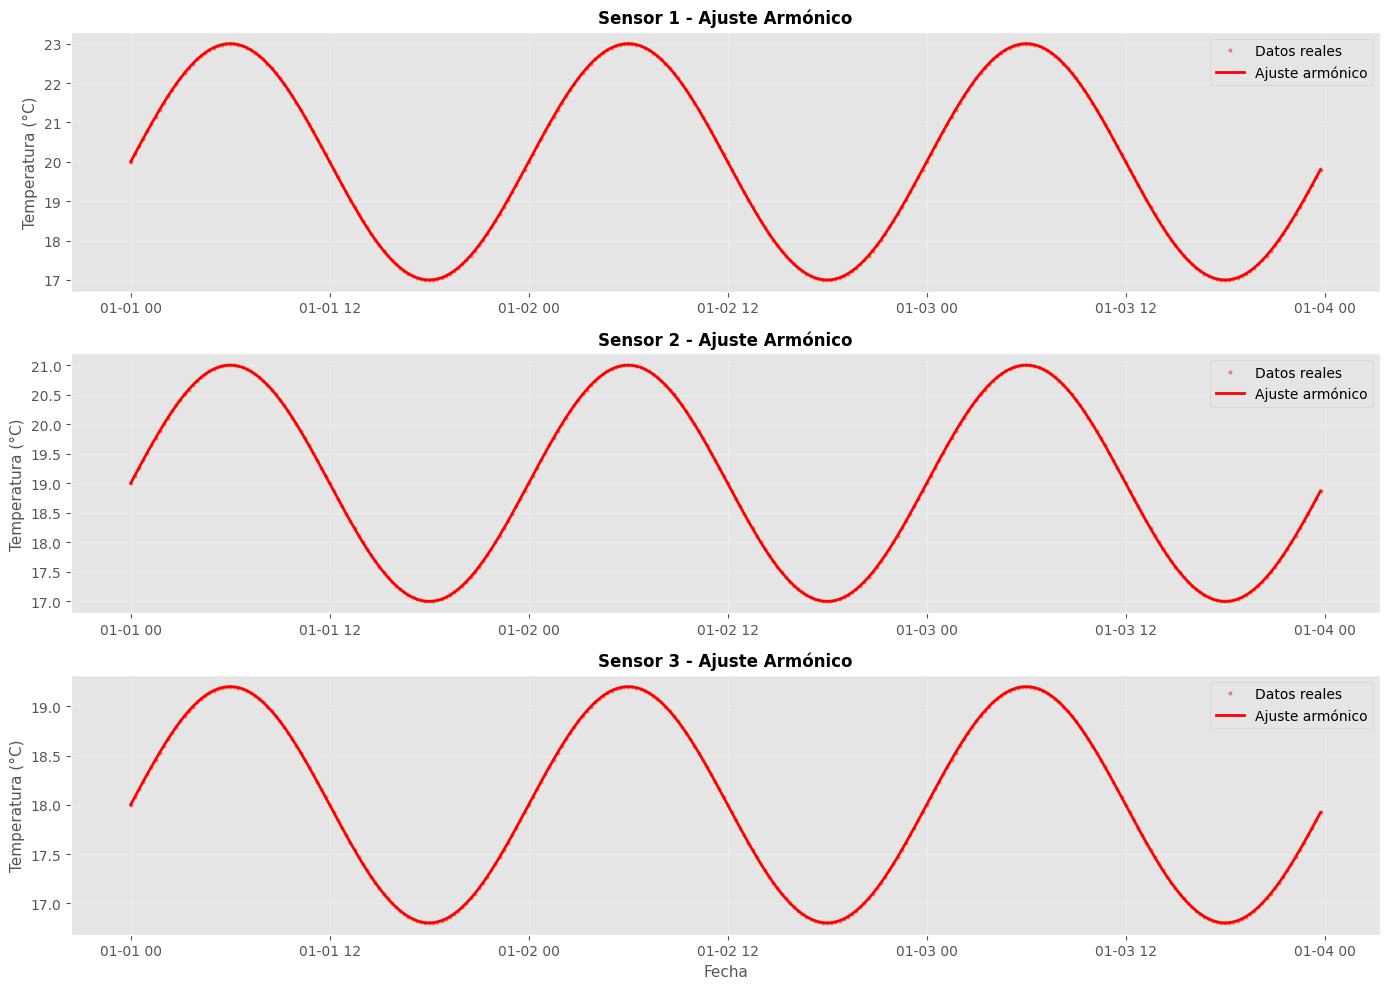

✅ Ajuste armónico exitoso en los 3 sensores


In [27]:
# Visualizar ajuste del modelo
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Generar predicciones del modelo
temp1_fitted = harmonic_model(time_hours, params1['mean'], params1['amplitude'], 
                                params1['omega'], params1['phase'])
temp2_fitted = harmonic_model(time_hours, params2['mean'], params2['amplitude'], 
                                params2['omega'], params2['phase'])
temp3_fitted = harmonic_model(time_hours, params3['mean'], params3['amplitude'], 
                                params3['omega'], params3['phase'])

# Sensor 1
axes[0].plot(df_aligned['fecha'], df_aligned['temp1'], 'o', markersize=2, 
             alpha=0.5, label='Datos reales')
axes[0].plot(df_aligned['fecha'], temp1_fitted, 'r-', linewidth=2, 
             label='Ajuste armónico')
axes[0].set_ylabel('Temperatura (°C)', fontsize=11)
axes[0].set_title('Sensor 1 - Ajuste Armónico', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Sensor 2
axes[1].plot(df_aligned['fecha'], df_aligned['temp2'], 'o', markersize=2, 
             alpha=0.5, label='Datos reales')
axes[1].plot(df_aligned['fecha'], temp2_fitted, 'r-', linewidth=2, 
             label='Ajuste armónico')
axes[1].set_ylabel('Temperatura (°C)', fontsize=11)
axes[1].set_title('Sensor 2 - Ajuste Armónico', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Sensor 3
axes[2].plot(df_aligned['fecha'], df_aligned['temp3'], 'o', markersize=2, 
             alpha=0.5, label='Datos reales')
axes[2].plot(df_aligned['fecha'], temp3_fitted, 'r-', linewidth=2, 
             label='Ajuste armónico')
axes[2].set_xlabel('Fecha', fontsize=11)
axes[2].set_ylabel('Temperatura (°C)', fontsize=11)
axes[2].set_title('Sensor 3 - Ajuste Armónico', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Ajuste armónico exitoso en los 3 sensores")

## 6. Cálculo de ΔA y Δφ entre Sensores

Estos parámetros son fundamentales para estimar el flujo vertical en VFLUX2:
- **ΔA**: Atenuación de amplitud entre sensores (logaritmo del ratio)
- **Δφ**: Desfase temporal (diferencia de fases)

In [28]:
# Extraer amplitudes y fases
A1 = params1['amplitude']
A2 = params2['amplitude']
A3 = params3['amplitude']

phi1 = params1['phase']
phi2 = params2['phase']
phi3 = params3['phase']

# Calcular ΔA (atenuación logarítmica)
delta_A_12 = np.log(A1 / A2)  # Entre sensor 1 y 2
delta_A_23 = np.log(A2 / A3)  # Entre sensor 2 y 3
delta_A_13 = np.log(A1 / A3)  # Entre sensor 1 y 3

# Calcular Δφ (desfase)
delta_phi_12 = phi2 - phi1  # Entre sensor 1 y 2
delta_phi_23 = phi3 - phi2  # Entre sensor 2 y 3
delta_phi_13 = phi3 - phi1  # Entre sensor 1 y 3

# Mostrar resultados
print("=" * 70)
print("PARÁMETROS DE ATENUACIÓN Y DESFASE")
print("=" * 70)
print(f"\n{'Par de Sensores':<20} {'ΔA (adim.)':<20} {'Δφ (rad)':<20}")
print("-" * 70)
print(f"{'Sensor 1 → 2':<20} {delta_A_12:>19.4f} {delta_phi_12:>19.4f}")
print(f"{'Sensor 2 → 3':<20} {delta_A_23:>19.4f} {delta_phi_23:>19.4f}")
print(f"{'Sensor 1 → 3':<20} {delta_A_13:>19.4f} {delta_phi_13:>19.4f}")
print("=" * 70)

print("\n📊 Interpretación:")
print(f"   • ΔA > 0: La amplitud disminuye con la profundidad (atenuación)")
print(f"   • Δφ > 0: El sensor profundo va retrasado respecto al superficial")
print(f"\n✅ Estos valores serán usados en los métodos VFLUX para calcular flujo vertical")

PARÁMETROS DE ATENUACIÓN Y DESFASE

Par de Sensores      ΔA (adim.)           Δφ (rad)            
----------------------------------------------------------------------
Sensor 1 → 2                      0.4057              0.0000
Sensor 2 → 3                      0.5110              0.0000
Sensor 1 → 3                      0.9167              0.0000

📊 Interpretación:
   • ΔA > 0: La amplitud disminuye con la profundidad (atenuación)
   • Δφ > 0: El sensor profundo va retrasado respecto al superficial

✅ Estos valores serán usados en los métodos VFLUX para calcular flujo vertical


## 7. Resumen y Próximos Pasos

### ✅ Completado en este notebook:
1. Carga exitosa de datos sintéticos
2. Alineación temporal de los 3 sensores
3. Visualización de series temporales
4. Análisis espectral FFT confirmando frecuencia diaria
5. Ajuste de modelo armónico con excelente precisión
6. Cálculo de ΔA y Δφ entre pares de sensores

### 🎯 Próximos pasos:
1. **Implementar `harmonic_analysis.py`** con todas las funciones validadas aquí
2. **Desarrollar `vflux_methods.py`** con los 5 métodos de flujo:
   - McCallum (principal)
   - Hatch - Amplitud
   - Hatch - Fase
   - Keery
   - Luce
3. **Crear notebook `02_solver_vflux.ipynb`** para calcular flujos verticales
4. **Validar con datos reales** y comparar con resultados de MATLAB